# Horizontal Grids

This notebook creates additional grid data, i.e. a boolean mask for defining the analysis domain and a distance map which contains the distance to coast for each pixel. Further, a visualisation of the two horizontal grids is created. The following figures are created in this notebook:
- Figure 2.1 Horizontal grids

In [1]:
import sys
sys.path.append('/nfs/kryo/work/maxsimon/master-thesis/scripts/')

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

from romstools.romsrun import RomsRun
from romstools.psd import get_dist, prepare_axis_for_psd, plot_single_psd
from romstools.utils import get_area_map
from romstools.plot import plot_data
from romstools.slice import slice_on_rho_grid
from romstools.cmap import W2G, W2G_r

import scipy.signal as sig
import scipy.stats as stat

import cartopy.crs as ccrs
import cartopy

import warnings
from datetime import timedelta as tdelta

from scipy.interpolate import NearestNDInterpolator

plt.rcParams.update({'font.size': 12})

## Utilities

In [2]:
def get_data_for_direction(data, direction='E'):
    """
    Flip data such that the coast is on the left
    """
    copy = None
    if direction == 'W':
        copy = data.copy()
    elif direction == 'E':
        copy = np.flip(data.copy(), axis=0)
    else:
        raise RuntimeError('Unknown Direction')
    return copy


def undo_data_for_direction(data, direction='E'):
    """
    Undo flipping done by get_data_for_direction
    """
    if direction == 'W':
        return data
    elif direction == 'E':
        return np.flip(data, axis=0)
    else:
        raise RuntimeError('Unknown Direction')

        
def get_coastline(mask_rho, radius, direction='E'):
    """
    Get the coastline of a domain.
    """
    mask_copy = get_data_for_direction(mask_rho, direction)    
    mask_copy[radius:, :] = 1
    return np.argmax(mask_copy, axis=0)


def get_distance_map(grid_data, radius=100, direction='E'):
    """
    Get a distance map, i.e. an array with same shape as grid where the entry is the distance to the coast in km.
    This assumes that constant-xi-lines are perpendicular to the coast!
    """
    grid_spaces = get_data_for_direction(1/(grid_data.pn.values * 1000), direction)
    dist_to_start = np.cumsum(grid_spaces, axis=0)
    
    coastline = get_coastline(grid_data.mask_rho.values, radius=80, direction=direction)
    
    xi_offsets = np.array([
        dist_to_start[coastline[xi], xi] for xi in range(grid_spaces.shape[1])
    ])
    
    mask = dist_to_start.copy()
    mask -= xi_offsets
    mask[get_data_for_direction(grid_data.mask_rho.values, direction) == 0] = np.nan
    
    return undo_data_for_direction(mask)


def get_distance_line(dist, distmap, lon, lat):
    """
    Get the coordinates (both LonLat and rho) of a line with constant distance to coast
    """
    assert lon.shape[0] == lat.shape[0]
    assert lon.shape[1] == lat.shape[1]
    assert lon.shape[0] == distmap.shape[0]
    assert lon.shape[1] == distmap.shape[1]
    
    xi_range = np.arange(distmap.shape[1])
    idxs = []
    
    for xi in xi_range:
        # there is no valid point
        if np.count_nonzero(np.isfinite(distmap[:, xi])) == 0:
            continue
        # get optimal eta
        eta = np.nanargmin(np.abs(distmap[:, xi] - dist))
        # check if eta is really close
        if np.abs(distmap[eta, xi] - dist) > 0.1*dist:
            continue
        idxs.append((eta, xi))
        
    # format for plot function
    line = [
            [lon[idx] for idx in idxs], 
            [lat[idx] for idx in idxs],
            [idx[0] for idx in idxs],
            [idx[1] for idx in idxs]
        ]
    return line


def print_area(area_map, distance_map, lower_bound=0, upper_bound=np.inf, expected=None):
    """
    Output the total area enclosed in specified bounds
    """
    area = np.sum(
        area_map[np.logical_and(distance_map >= lower_bound, distance_map < upper_bound)]
    )
    out = '{:.0f}km - {:.0f}km: {:.3f}km²'.format(lower_bound, upper_bound, area)
    if expected is not None:
        out += ' (expected: {:.3f}km², {:2.1f}%)'.format(expected, 100*expected/area)
    print(out)
    
    
def lin(lon, p1, p2):
    """
    Perform a linear regression between to points
    """
    m = ((p1[1] - p2[1])/(p1[0] - p2[0]))
    n = p1[1] - p1[0]*m
    return m * lon + n


def gruber_bound(lon, lat):
    """
    Get a boolean mask to match the analysis domain.
    This is called gruber_bound, gruber_mask, and so on, because it is the same as used in "Eddy Induced Reduction of Biological Productivity" (Gruber, 2011)
    """
    return np.logical_and(
        lat <= lin(lon, [-131, 41.5], [-124.2, 42]),
        lat >= lin(lon, [-125, 32.9], [-122, 33.8])
    )


def plot_grid_subdomain(grid_data_sliced, distance_map_sliced, gruber_mask, distance_line, xlim=None, ylim=None):
    """
    Plot a subdomain to a grid
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    gs = ax[0].get_gridspec()
    ax[0].remove()
    ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    
    # in rho-coords
    plot_data(grid_data_sliced, distance_map_sliced, ax=ax_map, lon_name='lon_rho', lat_name='lat_rho', cmap='winter_r', cmap_subd='coolwarm_r', vmin=1800, vmax=2000, highlight_subdomain=gruber_mask, colorbar=False, as_contourfill=True, alpha=0.5, highlight_subdomain_alpha=0.2, grid='both');
    for line in distance_line:
        ax_map.plot(line[0], line[1], transform=ccrs.PlateCarree(), color='black')
    
    if xlim is not None:
        ax_map.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax_map.set_ylim(ylim[0], ylim[1])

    ax_map.set_xlabel('Lon')
    ax_map.set_ylabel('Lat')
    
    # in lon-lat
    plot_data(grid_data_sliced, distance_map_sliced, ax=ax[1], lon_name='lon_rho', lat_name='lat_rho', cmap='winter_r', cmap_subd='coolwarm_r', vmin=90000, vmax=91000, highlight_subdomain=gruber_mask, colorbar=False, as_contourfill=False, alpha=0.5, highlight_subdomain_alpha=0.2, grid='both');
    for line in distance_line:
        ax[1].plot(line[2], line[3], color='black')

    plt.show()

## pactcs30

In [3]:
# load data
grid_data_meso = xr.open_dataset('/nfs/kryo/work/maxsimon/data/pactcs30_clim_bidaily_sd/orig_grid.nc')
distance_map_meso = get_distance_map(grid_data_meso)

# define a possible subdomain to reduce output size
MESOSCALE_GRID_SLICE = (slice(350, None, None), slice(18, 484, None))

# slice data to this subdomain
grid_data_meso_sliced = slice_on_rho_grid(grid_data_meso, eta_rho_slice=MESOSCALE_GRID_SLICE[0], xi_rho_slice=MESOSCALE_GRID_SLICE[1])
distance_map_meso_sliced = distance_map_meso[MESOSCALE_GRID_SLICE]

# create a boolean mask within this reduced domain to match the domain from paper
MESOSCALE_GRUBER_MASK = np.logical_and(
    gruber_bound(grid_data_meso_sliced.lon_rho.values - 360, grid_data_meso_sliced.lat_rho.values),
    distance_map_meso_sliced <= 1000
)

# calculate the distance lines
meso_lines = [get_distance_line(dist, distance_map_meso[MESOSCALE_GRID_SLICE], grid_data_meso_sliced.lon_rho.values, grid_data_meso_sliced.lat_rho.values) for dist in [200, 800]] 

# calculate the enclosed area
area_map_meso = get_area_map(grid_data_meso_sliced)
area_map_meso[grid_data_meso_sliced.mask_rho == 0] = 0

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app


In [4]:
## calculate the area within given zones (this compares to Nikis Paper from 2011)
print_area(area_map_meso[MESOSCALE_GRUBER_MASK], distance_map_meso_sliced[MESOSCALE_GRUBER_MASK], upper_bound=100, expected=96656)
print_area(area_map_meso[MESOSCALE_GRUBER_MASK], distance_map_meso_sliced[MESOSCALE_GRUBER_MASK], lower_bound=100, upper_bound=500, expected=420602)
print_area(area_map_meso[MESOSCALE_GRUBER_MASK], distance_map_meso_sliced[MESOSCALE_GRUBER_MASK], lower_bound=500, upper_bound=1000, expected=588201)

0km - 100km: 95862.595km² (expected: 96656.000km², 100.8%)
100km - 500km: 409483.133km² (expected: 420602.000km², 102.7%)
500km - 1000km: 577334.807km² (expected: 588201.000km², 101.9%)


/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:123: RuntimeWarning: invalid value encountered in greater
  data_main[data_main > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:124: RuntimeWarning: invalid value encountered in less
  data_main[data_main < vmin] = vmin
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:128: RuntimeWarning: invalid value encountered in greater
  data_subd[data_subd > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:129: RuntimeWarning: invalid value encountered in less
  data_subd[data_subd < vmin] = vmin


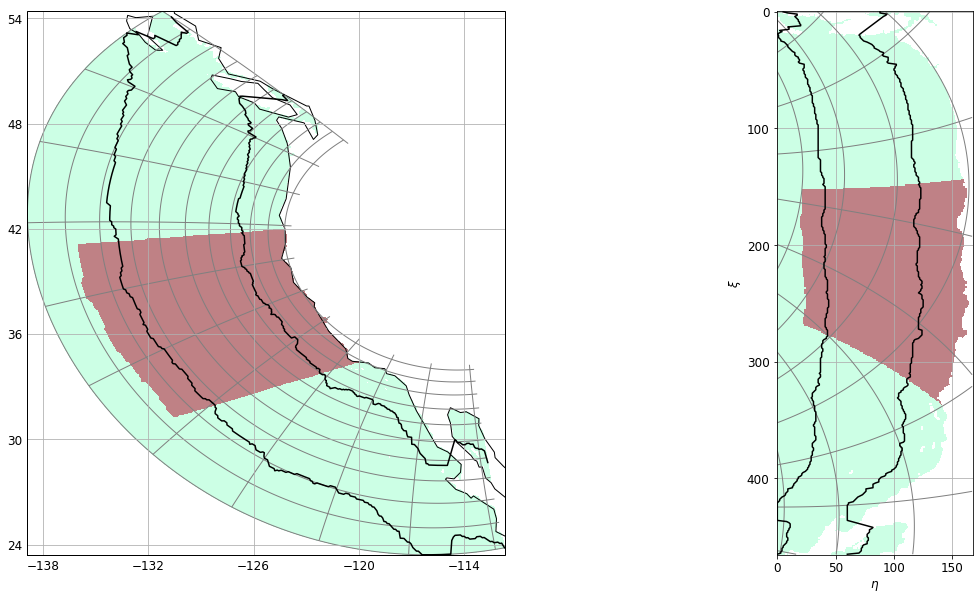

In [5]:
plot_grid_subdomain(grid_data_meso_sliced, distance_map_meso_sliced, MESOSCALE_GRUBER_MASK, meso_lines)

In [6]:
# save additional grid data
np.savez('/nfs/kryo/work/maxsimon/data/pactcs30/grid.npz', 
         distance_map=distance_map_meso_sliced, 
         distance_lines=np.array(meso_lines),
         gruber_mask=MESOSCALE_GRUBER_MASK
)

## pactcs15

In [7]:
# load data
grid_data_subm = xr.open_dataset('/nfs/kryo/work/maxsimon/data/pactcs15/grid.nc')
distance_map_subm = get_distance_map(grid_data_subm)

# create a boolean mask within this reduced domain to match the domain from paper
SUBM_GRUBER_MASK = np.logical_and(
    gruber_bound(grid_data_subm.lon_rho.values, grid_data_subm.lat_rho.values),
    distance_map_subm <= 1000
)

# calculate the distance lines
subm_lines = [get_distance_line(dist, distance_map_subm, grid_data_subm.lon_rho.values, grid_data_subm.lat_rho.values) for dist in [200, 800]] 

# calculate the enclosed area
area_map_subm = get_area_map(grid_data_subm)
area_map_subm[grid_data_subm.mask_rho == 0] = 0

/nfs/kryo/work/maxsimon/envs/lagrangian/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


In [8]:
print_area(area_map_subm[SUBM_GRUBER_MASK], distance_map_subm[SUBM_GRUBER_MASK], upper_bound=100, expected=96656)
print_area(area_map_subm[SUBM_GRUBER_MASK], distance_map_subm[SUBM_GRUBER_MASK], lower_bound=100, upper_bound=500, expected=420602)
print_area(area_map_subm[SUBM_GRUBER_MASK], distance_map_subm[SUBM_GRUBER_MASK], lower_bound=500, upper_bound=1000, expected=588201)

0km - 100km: 94605.578km² (expected: 96656.000km², 102.2%)
100km - 500km: 409668.000km² (expected: 420602.000km², 102.7%)
500km - 1000km: 554926.875km² (expected: 588201.000km², 106.0%)


/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:123: RuntimeWarning: invalid value encountered in greater
  data_main[data_main > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:124: RuntimeWarning: invalid value encountered in less
  data_main[data_main < vmin] = vmin
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:128: RuntimeWarning: invalid value encountered in greater
  data_subd[data_subd > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:129: RuntimeWarning: invalid value encountered in less
  data_subd[data_subd < vmin] = vmin


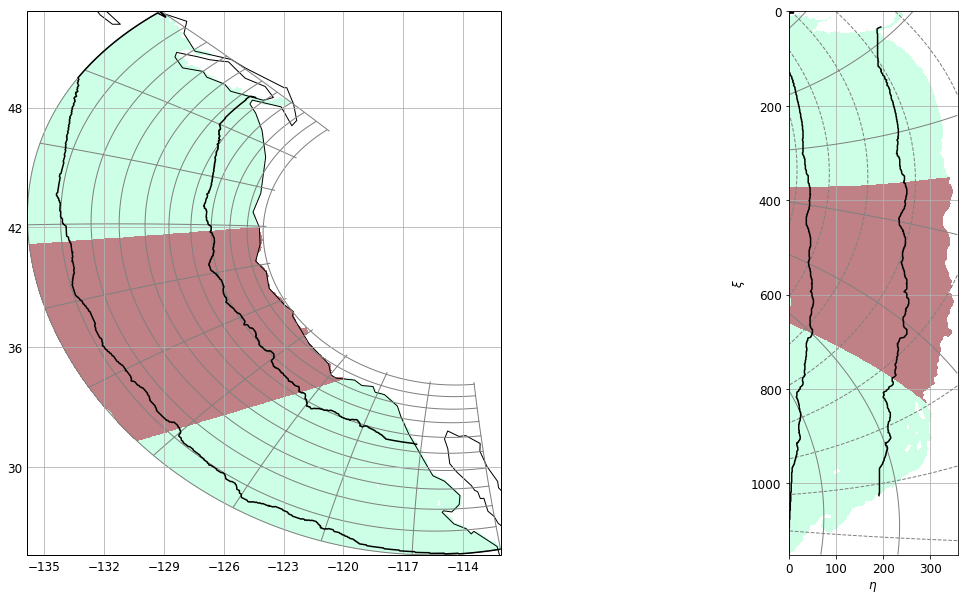

In [9]:
plot_grid_subdomain(grid_data_subm, distance_map_subm, SUBM_GRUBER_MASK, subm_lines)

In [10]:
# save additional grid data
np.savez('/nfs/kryo/work/maxsimon/data/pactcs15/grid.npz', 
         distance_map=distance_map_subm, 
         distance_lines=np.array(subm_lines),
         gruber_mask=SUBM_GRUBER_MASK
)

## Visualisation of the two grids

In [11]:
def plot_grid(ax, g, step_x=30, step_y=40, p=ccrs.PlateCarree(), color='k', lw_major=1, show_last=True):
    # grep some gridlines and plot them as lines
    for i in range(0, g.lon_rho.shape[0], step_x):
        if i % (3*step_x) == 0:
            ax.plot(g.lon_rho[i], g.lat_rho[i], transform=p, color=color, lw=lw_major)
        else:
            ax.plot(g.lon_rho[i], g.lat_rho[i], transform=p, color=color, lw=0.5)
    # make sure the last line is always shown
    if show_last:
        ax.plot(g.lon_rho[-1], g.lat_rho[-1], transform=p, color=color)
    
    # same in y direction
    for i in range(0, g.lon_rho.shape[1], step_y):
        if i % (3*step_y) == 0:
            ax.plot(g.lon_rho[:, i], g.lat_rho[:, i], transform=p, color=color, lw=lw_major)
        else:
            ax.plot(g.lon_rho[:, i], g.lat_rho[:, i], transform=p, color=color, lw=0.5)
    if show_last:
        ax.plot(g.lon_rho[:, -1], g.lat_rho[:, -1], transform=p, color=color)

/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:123: RuntimeWarning: invalid value encountered in greater
  data_main[data_main > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:124: RuntimeWarning: invalid value encountered in less
  data_main[data_main < vmin] = vmin
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:128: RuntimeWarning: invalid value encountered in greater
  data_subd[data_subd > vmax] = vmax
/nfs/kryo/work/maxsimon/master-thesis/scripts/romstools/plot.py:129: RuntimeWarning: invalid value encountered in less
  data_subd[data_subd < vmin] = vmin


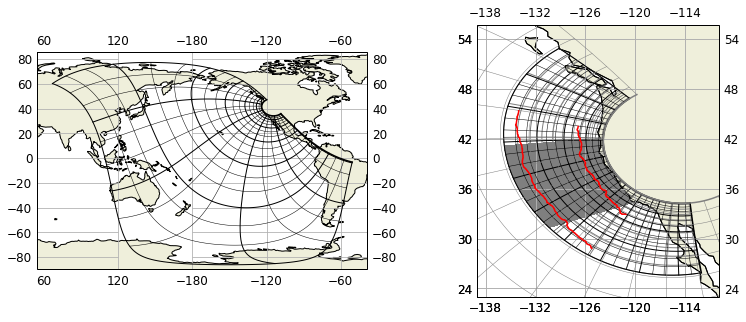

In [12]:
# create reusable projections
proj = ccrs.PlateCarree(central_longitude=180)
proj2 = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 2, subplot_kw={'projection': proj}, figsize=(13, 5))

## pactcs30

plot_grid(ax[0], grid_data_meso)
# add lon-lat grid in background
gl = ax[0].gridlines(crs=proj2, draw_labels=True)
gl.xlocator = mticker.FixedLocator([-60, -120, -180, 120, 60])
# add land and coastlines
ax[0].add_feature(cartopy.feature.LAND)
ax[0].coastlines()


## pactcs15
plot_grid(ax[1], grid_data_subm)
# plot also pactcs30 again (sliced)
plot_grid(ax[1], slice_on_rho_grid(grid_data_meso, eta_rho_slice=slice(250, None), xi_rho_slice=slice(None, None)), color='gray', lw_major=0.5, show_last=True)
# plot analysis domain
plot_data(grid_data_subm, distance_map_subm, ax=ax[1], lon_name='lon_rho', lat_name='lat_rho', cmap='winter_r', cmap_subd='gray', vmin=1800, vmax=2000, highlight_subdomain=SUBM_GRUBER_MASK, colorbar=False, as_contourfill=True, alpha=0.5, highlight_subdomain_alpha=0.0, grid='both');
# add distance lines
for line in subm_lines:
    ax[1].plot(line[0][250:800], line[1][250:800], transform=proj2, color='r')

# add lon-lat grid in background
gl = ax[1].gridlines(crs=proj2, draw_labels=True)
# add land and coastlines
ax[1].add_feature(cartopy.feature.LAND)
ax[1].coastlines()

# set extent for plot
ax[1].set_extent([-110, -139, 23, 55])

plt.savefig('figures/methods_grid.pdf')
plt.show()